# LLM Generated Text Detection

## import libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv
/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv
/kaggle/input/llm-generated-essays/ai_generated_train_essays.csv
/kaggle/input/llm-generated-essays/ai_generated_train_essays_gpt-4.csv


## read data

In [2]:
train_path = '/kaggle/input/llm-detect-ai-generated-text/train_essays.csv'
test_path = '/kaggle/input/llm-detect-ai-generated-text/test_essays.csv'
train_prompts_path = '/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
prompts = pd.read_csv(train_prompts_path)

In [3]:
train.tail()

,id,prompt_id,text,generated
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0
1377,ffe1ca0d,0,Cars have been around since the 1800's and hav...,0


In [4]:
test

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [5]:
prompts

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


there are only two distinct prompts

In [6]:
train['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

we see a significant class imbalance, with only 3 essays generated by LLMs

In [7]:
train[train['generated'] == 1]['prompt_id'].value_counts()

prompt_id
1    2
0    1
Name: count, dtype: int64

two of which are from prompt id=1 and one from id=0

In [8]:
print(train.isnull().sum())
print(test.isnull().sum())
print(prompts.isnull().sum())

id           0
prompt_id    0
text         0
generated    0
dtype: int64
id           0
prompt_id    0
text         0
dtype: int64
prompt_id       0
prompt_name     0
instructions    0
source_text     0
dtype: int64


no missing values

## Extra data

from: https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset

it contains 26k human written essays from the persuade corpus and AI generated ones from different LLMs including OSS ones

In [9]:
extra_train = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")

In [10]:
extra_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   label          44868 non-null  int64 
 2   prompt_name    44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB


RDizzl3_seven is a boolean indicating whether the essays were written in response to one of the seven essay prompts for the competition.

- "Car-free cities"
- "Does the electoral college work?"
- "Exploring Venus"
- "The Face on Mars"
- "Facial action coding system"
- "A Cowboy Who Rode the Waves"
- "Driverless cars"

In [11]:
extra_train

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False
...,...,...,...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44864,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44865,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44866,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True


In [12]:
extra_train = extra_train.rename(columns={'label': 'generated'})
extra_train = extra_train[extra_train.RDizzl3_seven == True] # filter for the 7 prompts

train = pd.concat([train, extra_train])

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21828 entries, 0 to 44867
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1378 non-null   object 
 1   prompt_id      1378 non-null   float64
 2   text           21828 non-null  object 
 3   generated      21828 non-null  int64  
 4   prompt_name    20450 non-null  object 
 5   source         20450 non-null  object 
 6   RDizzl3_seven  20450 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.3+ MB


In [14]:
print(train['generated'].value_counts())

generated
0    15625
1     6203
Name: count, dtype: int64


In [15]:
train.isnull().sum()

id               20450
prompt_id        20450
text                 0
generated            0
prompt_name       1378
source            1378
RDizzl3_seven     1378
dtype: int64

In [16]:
train.dropna(subset=['prompt_name'], inplace=True)

In [17]:
train.prompt_name.unique()

array(['Car-free cities', '"A Cowboy Who Rode the Waves"',
       'Exploring Venus', 'Facial action coding system',
       'The Face on Mars', 'Driverless cars',
       'Does the electoral college work?'], dtype=object)

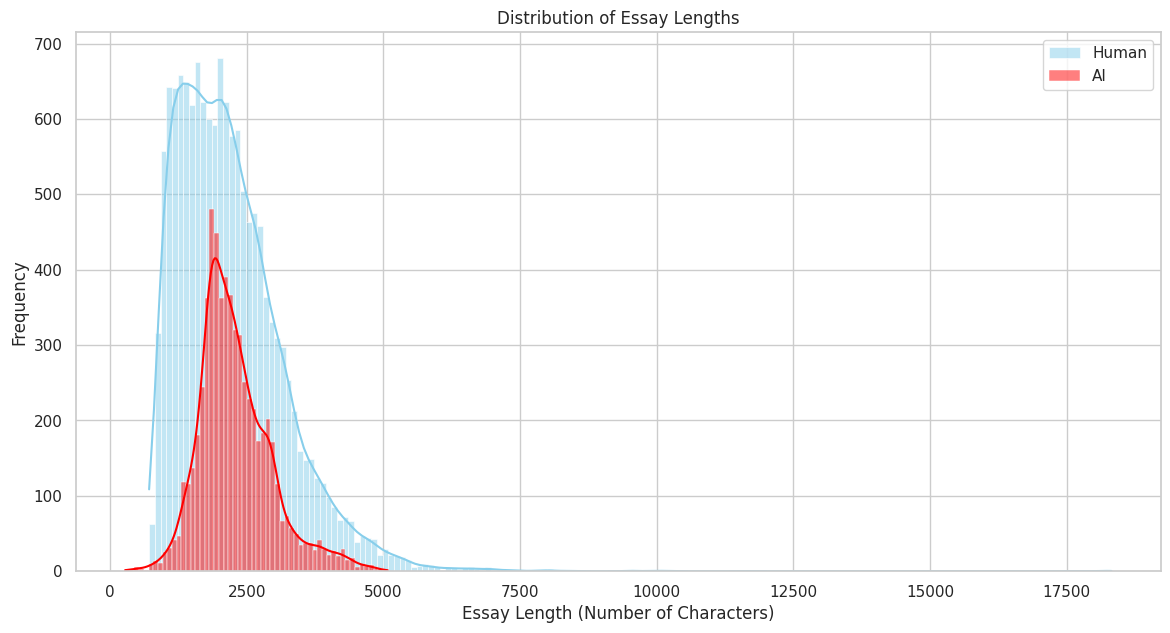

In [18]:
train['essay_length'] = train['text'].apply(len)

sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

sns.histplot(train[train['generated'] == 0]['essay_length'], color="skyblue", label='Human', kde=True)
sns.histplot(train[train['generated'] == 1]['essay_length'], color="red", label='AI', kde=True)

plt.title('Distribution of Essay Lengths')
plt.xlabel('Essay Length (Number of Characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

using a histogram with kernel density estimation, it shows AI has a tighter distribution, suggesting theyre more consistent in their outputs, while human essays have a winder distribution, indicating variation in essay length

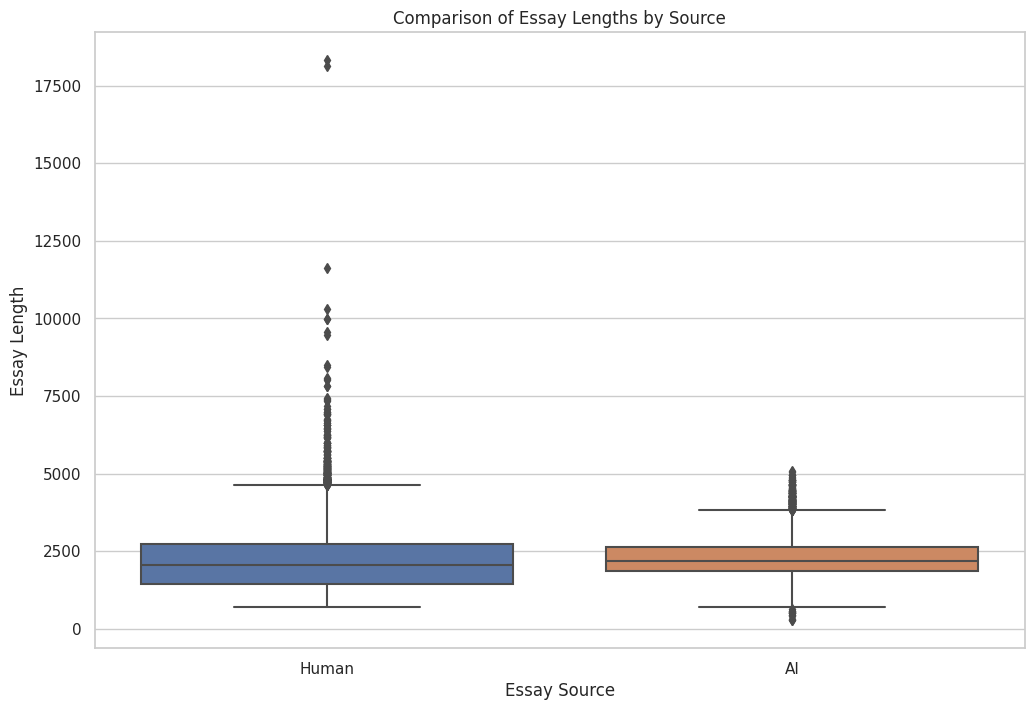

In [19]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='generated', y='essay_length', data=train)
plt.title('Comparison of Essay Lengths by Source')
plt.xlabel('Essay Source')
plt.ylabel('Essay Length')
plt.xticks([0, 1], ['Human', 'AI'])
plt.show()

the median essay length for humans are slightly lower than AI. the IQR for AI essays are more narrow, and human essays have significantly more outliers than AI ones

In [20]:
def get_text_metrics(text):
    words = text.split()
    sentences = text.split('.')
    word_count = len(words)
    unique_word_count = len(set(words))
    sentence_count = len(sentences)
    avg_word_length = sum(len(word) for word in words) / word_count if word_count > 0 else 0
    return word_count, unique_word_count, sentence_count, avg_word_length

train['metrics'] = train['text'].apply(get_text_metrics)
train[['word_count', 'unique_word_count', 'sentence_count', 'avg_word_length']] = pd.DataFrame(train['metrics'].tolist(), index=train.index)
train.drop('metrics', axis=1, inplace=True)

comparison_metrics = train.groupby('generated')[['word_count', 'unique_word_count', 'sentence_count', 'avg_word_length']].mean()
comparison_metrics

,word_count,unique_word_count,sentence_count,avg_word_length
generated,,,,
0,389.803368,201.140281,21.361965,4.549900
1,370.670645,190.196935,20.957258,5.155909


some insights into the stylistic and structural differences between the two

- AI essays have lower word count
- Human uses more unique words
- human essays write more sentences
- average word length is longer in AI, implying use of longer or more complex words.

In [ ]:
%%time

import regex as re

def normalize(text: str) -> str:
    # Replace with whitespace to separate '😃\n\nFor'
    text = text.replace(r"\n", r" ")
    text = text.replace(r"\r", r" ")
    # Drop puntuation
    text = re.sub(r"\p{P}", " ", text)
    # Remove extra spaces from '😃  For' to '😃 For'
    text = re.sub(r"\s+", r" ", text)
    # Remove leading and trailing whitespace
    text = text.strip()
    return text

train['text'] = train['text'].apply(lambda x: normalize(x))
test['text'] = test['text'].apply(lambda x: normalize(x))

normalize text in train and test set using regex to replace newlines, punctuation and standardizing whitespace. This ensurces uniformity and reduces noise

In [22]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.concat([train['text'], test['text']], axis=0)
vectorizer = TfidfVectorizer(ngram_range=(3, 4),
                             tokenizer=lambda x: re.findall(r'[^\W]+', x),
                             stop_words='english',
                             token_pattern=None,
                             strip_accents='unicode',
                             sublinear_tf=True,
                             max_features=50000
                             )
X = vectorizer.fit_transform(df)
y = train['generated']

CPU times: user 32.1 s, sys: 1.08 s, total: 33.1 s
Wall time: 33.2 s


here we apply a TF-IDF (term frequency - inverse document frequency) vectorization, with the following configuration

- ngram_range (ngrams for 3-4 word phrases)
- tokenizer: a custom function that tokenizes the text into words by splitting on punctuation and whitespace.
- stopwords: filter out english stop words
- strip_accents: normalize café -> cafe
- sublinear_tf: sublinear term frequency scaling, dampens the effect of terms that appear very frequently
- max_features: limits number of features to top 50000, reduces dimensionality of feature space and keeps memory low

## Regression

source: https://www.kaggle.com/code/x75a40890/ai-generated-text-detection-quick-baseline/notebook


see why non-NN methods work well: https://www.kaggle.com/competitions/llm-detect-ai-generated-text/discussion/454448


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report

def calculate_auc_scores_and_std(model, X, y, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    auc_scores = []

    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds_val = model.predict_proba(X_val)[:, 1]
        auc_score = roc_auc_score(y_val, preds_val)
        auc_scores.append(auc_score)

    avg_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    return auc_scores, avg_auc, std_auc

lr_model = LogisticRegression(solver="liblinear")
lr_auc_scores, lr_avg_auc, lr_std_auc = calculate_auc_scores_and_std(lr_model, X[:train.shape[0]], y)

print('Logistic Regression AUC Scores:', lr_auc_scores)
print('Logistic Regression Average AUC:', lr_avg_auc)
print('Logistic Regression AUC Standard Deviation:', lr_std_auc)

Logistic Regression AUC Scores: [0.9979745331069609, 0.99842246745897, 0.9979651952461801, 0.998203169213356, 0.9987425014148275]
Logistic Regression Average AUC: 0.9982615732880589
Logistic Regression AUC Standard Deviation: 0.00029353767818283695


we use AUC (Area Under the Receiver Operating Characteristic Curve) with cross validation to evaluate the performance.

The logistic regression model is has very high and consistent AUC scores across all folds, indicating a strong ability to distinguish between classes.

In [24]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(max_iter=1000, tol=1e-3, loss="modified_huber")
sgd_auc_scores, sgd_avg_auc, sgd_std_auc = calculate_auc_scores_and_std(sgd_model, X[:train.shape[0]], y)

print('SGD Classifier AUC Scores:', sgd_auc_scores)
print('SGD Classifier Average AUC:', sgd_avg_auc)
print('SGD Classifier AUC Standard Deviation:', sgd_std_auc)

SGD Classifier AUC Scores: [0.9988097057159027, 0.9991839275608376, 0.9987818336162989, 0.998396859083192, 0.9982782965478212]
SGD Classifier Average AUC: 0.9986901245048104
SGD Classifier AUC Standard Deviation: 0.000323158957478536


Huber loss is a loss function for robust regression, it's like MSE when the error is small, but MAE when error is large, making it less sensitive to outliers. We use a modified huber loss, which provides a smooth loss that is robust to outliers.

The SGD Classifier shows a marginally better average performance than logistic regression, with high AUC scores but a bit more variability across folds.

In [25]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_auc_scores, xgb_avg_auc, xgb_std_auc = calculate_auc_scores_and_std(xgb_model, X[:train.shape[0]], y)

print('XGBoost AUC Scores:', xgb_auc_scores)
print('XGBoost Average AUC:', xgb_avg_auc)
print('XGBoost AUC Standard Deviation:', xgb_std_auc)

XGBoost AUC Scores: [0.9895783814374646, 0.9861627051499717, 0.9868027730616864, 0.9854947651386532, 0.9859668930390493]
XGBoost Average AUC: 0.986801103565365
XGBoost AUC Standard Deviation: 0.0014507415338486979


XGBoost, while still performing well, shows a drop in AUC scores compared to logistic regression and SGD Classifier. It also demonstrates more variation across the cross-validation folds.

## Ensemble learning

we train an ensemble model to capitalize on the strengths and mitigate the weakness of individual models. by combining models, we can achieve higher performance and better generalization. it's particularly useful when different models capture different aspects of the data

We use a Voting classifier, which aggregates the prediction of each base classifier and predicts the final output based on the majority voting of the classifiers.

In our case, it's set to 'soft', which means the classifier will predict the class label based on the argmax of the sums of the predicted probabilities. As apposed to 'hard' voting, where class with majority of votes is chosen. why use soft? it is often more flexible and can yield better performance, as it takes into account the confidence level of predictions from each classifier

In [26]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[('lr', lr_model),('sgd', sgd_model)], voting='soft')
ensemble.fit(X[:train.shape[0]], train.generated)

VotingClassifier(estimators=[('lr', LogisticRegression(solver='liblinear')),
                             ('sgd', SGDClassifier(loss='modified_huber'))],
                 voting='soft')

In [27]:
preds_test = ensemble.predict_proba(X[train.shape[0]:])[:,1]
preds_test

array([0.26954307, 0.26954307, 0.26954307])

this is the probability of each instances being class 1, in other words, is generated by an LLM.

In [28]:
pd.DataFrame({'id': test["id"], 'generated': preds_test}).to_csv('submission.csv', index=False)

## Clustering

source: https://www.kaggle.com/code/cpmpml/ai-generated-text-detection-cluster/notebook

In [29]:
%%time 

df = pd.concat([train['text'], test['text']], axis=0)
vectorizer = TfidfVectorizer(ngram_range=(3, 5),
                             sublinear_tf=True,
                             )
X = vectorizer.fit_transform(df)
y = train['generated']

CPU times: user 1min 28s, sys: 2.83 s, total: 1min 31s
Wall time: 1min 30s


we create a simpler vectorizer to perform clustering of the text

In [30]:
from sklearn.cluster import KMeans
import umap

embedding = umap.UMAP(random_state=2024, n_components=2).fit_transform(X)
cl = KMeans(7)

embeddings_human = embedding[:train.shape[0]]
embeddings_human = embeddings_human[train.generated == 0]

cl.fit(embeddings_human)
dist = cl.transform(embedding).min(1)
clusters = cl.predict(embedding)

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Here we use UMAP (Uniform Manifold Approximation and Projection) for dimensionality reduction and KMeans for clustering.

- we set n_components=2 which reduces data to a 2-dimensional space
- we set k=7 because we have 7 prompts, so we expect 7 clusters
- we filter for human essay embeddings
- .min(1) computes the distance of each point in this reduced space to the nearest cluster center
- predict(embedding) assigns each data point to one of the 7 closest cluster center

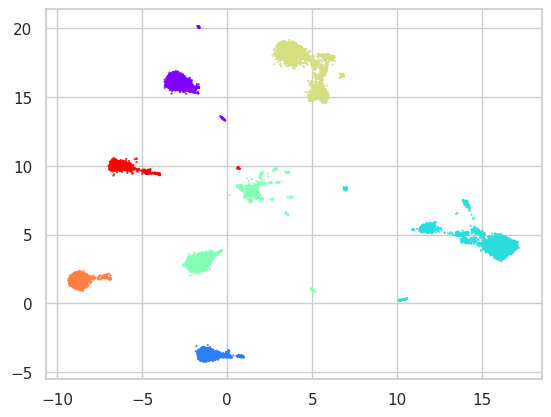

In [31]:
plt.scatter(embedding[:, 0], embedding[:, 1], marker='.', s=1, cmap='rainbow', c=clusters)

we see the 7 prompts form 7 distinct clusters in this reduced space

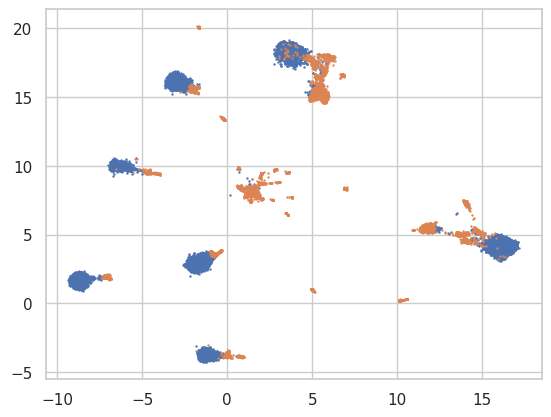

In [32]:
plt.scatter(embedding[:train.shape[0]][train.generated == 0 , 0], embedding[:train.shape[0]][train.generated == 0, 1], marker='.', s=2)
plt.scatter(embedding[:train.shape[0]][train.generated == 1 , 0], embedding[:train.shape[0]][train.generated == 1, 1], marker='.', s=2)

separating by AI and not AI, we see that it covers each cluster

In [33]:
preds_train = dist[:train.shape[0]]
roc_auc_score(train.generated, preds_train)

0.9857796604414262

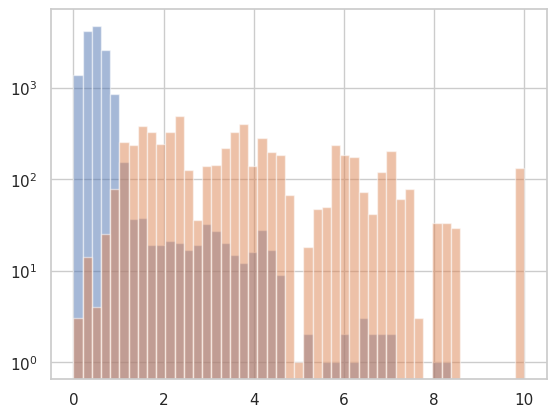

In [34]:
bins = np.linspace(0, 10)
_ = plt.hist(preds_train[train.generated == 0], bins=bins, alpha=0.5, log=True)
_ = plt.hist(preds_train[train.generated == 1], bins=bins, alpha=0.5, log=True)

the historgram shows there is a difference in distribution to the nearest clustesr for the two classes, which further supports the high ROC AUC score.

In [35]:
preds_test = dist[train.shape[0]:]
preds_test

array([0.3829122, 1.0900377, 1.16649  ], dtype=float32)

In [36]:
pd.DataFrame({'id':test["id"],'generated':preds_test}).to_csv('submission.csv', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a605a3e6-1564-47b2-94e7-842290ba7692' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>